In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt
from matplotlib import gridspec
import warnings

In [2]:
# Read the data
df = pd.read_csv('model-transformation-languages.csv')

In [3]:
# Drop the rows which have null value in thier outcome column
df_clean = df.dropna()

In [4]:
# Extract the desired data from the DataFrame
La = df_clean[ (df_clean.language == 'a') ]
La_Com = La[(La.task == 'ComprehendFM') | (La.task == 'ComprehendRE')]
La_Cha = La[(La.task == 'ChangeFM') | (La.task == 'ChangeRE')]
La_Cre = La[(La.task == 'CreateFM') | (La.task == 'CreateRE')]

Lq = df_clean[ (df_clean.language == 'q') ]
Lq_Com = Lq[(Lq.task == 'ComprehendFM') | (Lq.task == 'ComprehendRE')]
Lq_Cha = Lq[(Lq.task == 'ChangeFM') | (Lq.task == 'ChangeRE')]
Lq_Cre = Lq[(Lq.task == 'CreateFM') | (Lq.task == 'CreateRE')]

Lx = df_clean[ (df_clean.language == 'x') ]
Lx_Com = Lx[(Lx.task == 'ComprehendFM') | (Lx.task == 'ComprehendRE')]
Lx_Cha = Lx[(Lx.task == 'ChangeFM') | (Lx.task == 'ChangeRE')]
Lx_Cre = Lx[(Lx.task == 'CreateFM') | (Lx.task == 'CreateRE')]

In [5]:
# Prepare parameters to model
y = df_clean.outcome.to_numpy()
μy = np.mean(y)
σy = np.std(y)

# Prepare observed data to likelihood function
y_a_Com = La_Com.outcome
y_a_Cha = La_Cha.outcome
y_a_Cre = La_Cre.outcome

y_q_Com = Lq_Com.outcome
y_q_Cha = Lq_Cha.outcome
y_q_Cre = Lq_Cre.outcome

y_x_Com = Lx_Com.outcome
y_x_Cha = Lx_Cha.outcome
y_x_Cre = Lx_Cre.outcome

y_joint = [y_a_Com, y_a_Cha, y_a_Cre, y_q_Com, y_q_Cha, y_q_Cre, y_x_Com, y_x_Cha, y_x_Cre]

![title](model.png)

In [6]:
# The model
with pm.Model() as TL:
    
    σ = pm.Uniform('σ',lower=σy/1000,upper=σy*1000,shape=9)
    μ = pm.Normal('μ',mu=μy,sigma=σy*100,shape=9)
    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)

    # Likelihood
    [pm.StudentT(f'obs_{i}', nu=ν, mu=μ[i], sigma=σ[i], observed=y_joint[i]) for i in range(9)]
    # For ploting normality with ease     
    pm.Deterministic('log10_ν',np.log10(ν))

I assume that the data is normally distributed. 
The model utilizes t distribution for describing noise in the data and handle the outliers. A Uniform (σ), Normal (μ) and Exponential distribution (ν_minus_one) are used for the prior distributions on parameters of the t distribution. The Uniform distribution is applied to the scale parameter, Normal distribution to the mean parameter and Exponential distribution to the normality parameter that controls the heaviness of the tails. The parameters of μ are set to be noncommittal by setting its mean (M in the graph) to the actual mean of the collected data and its standard deviation (S in the graph) to 100 times larger than the standard deviation of the data. The parameters of σ (L and H in the graph) are chosen in a way that put a broad uniform distribution directly on the scale parameter of the likelihood function. Last but not least the prior normality parameter ν is a continuous value between 1 and infinity with an equal opportunity to small values of ν (less than 30) and larger values of ν (greater than 30) since the t distribution with ν > 30  is essentially a normal distribution. 

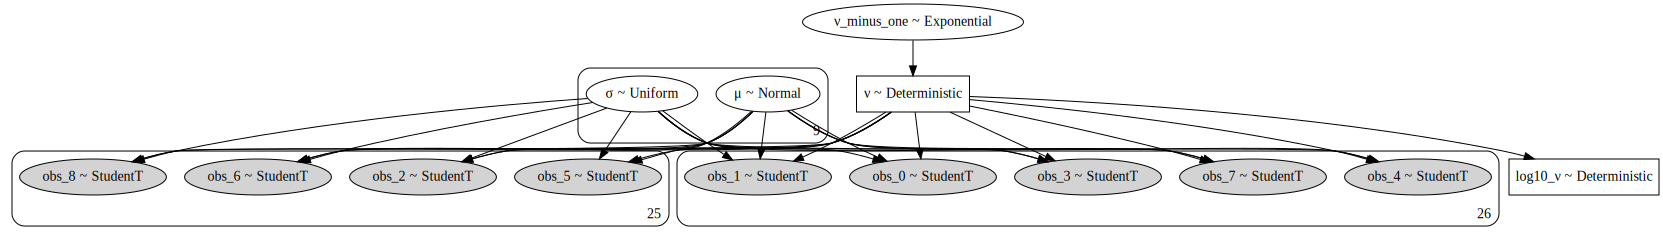

In [7]:
pm.model_to_graphviz(TL)

I draw 21000 samples from the posterior using NUTS sampler which is the default sampler in pymc3.

In [8]:
with TL:
    trace_TL=pm.sample(21000, chains=4, cores=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, μ, σ]
Sampling 4 chains, 0 divergences: 100%|██████████| 88000/88000 [02:56<00:00, 498.61draws/s]


Let's check autocorrelation for our three parameters.

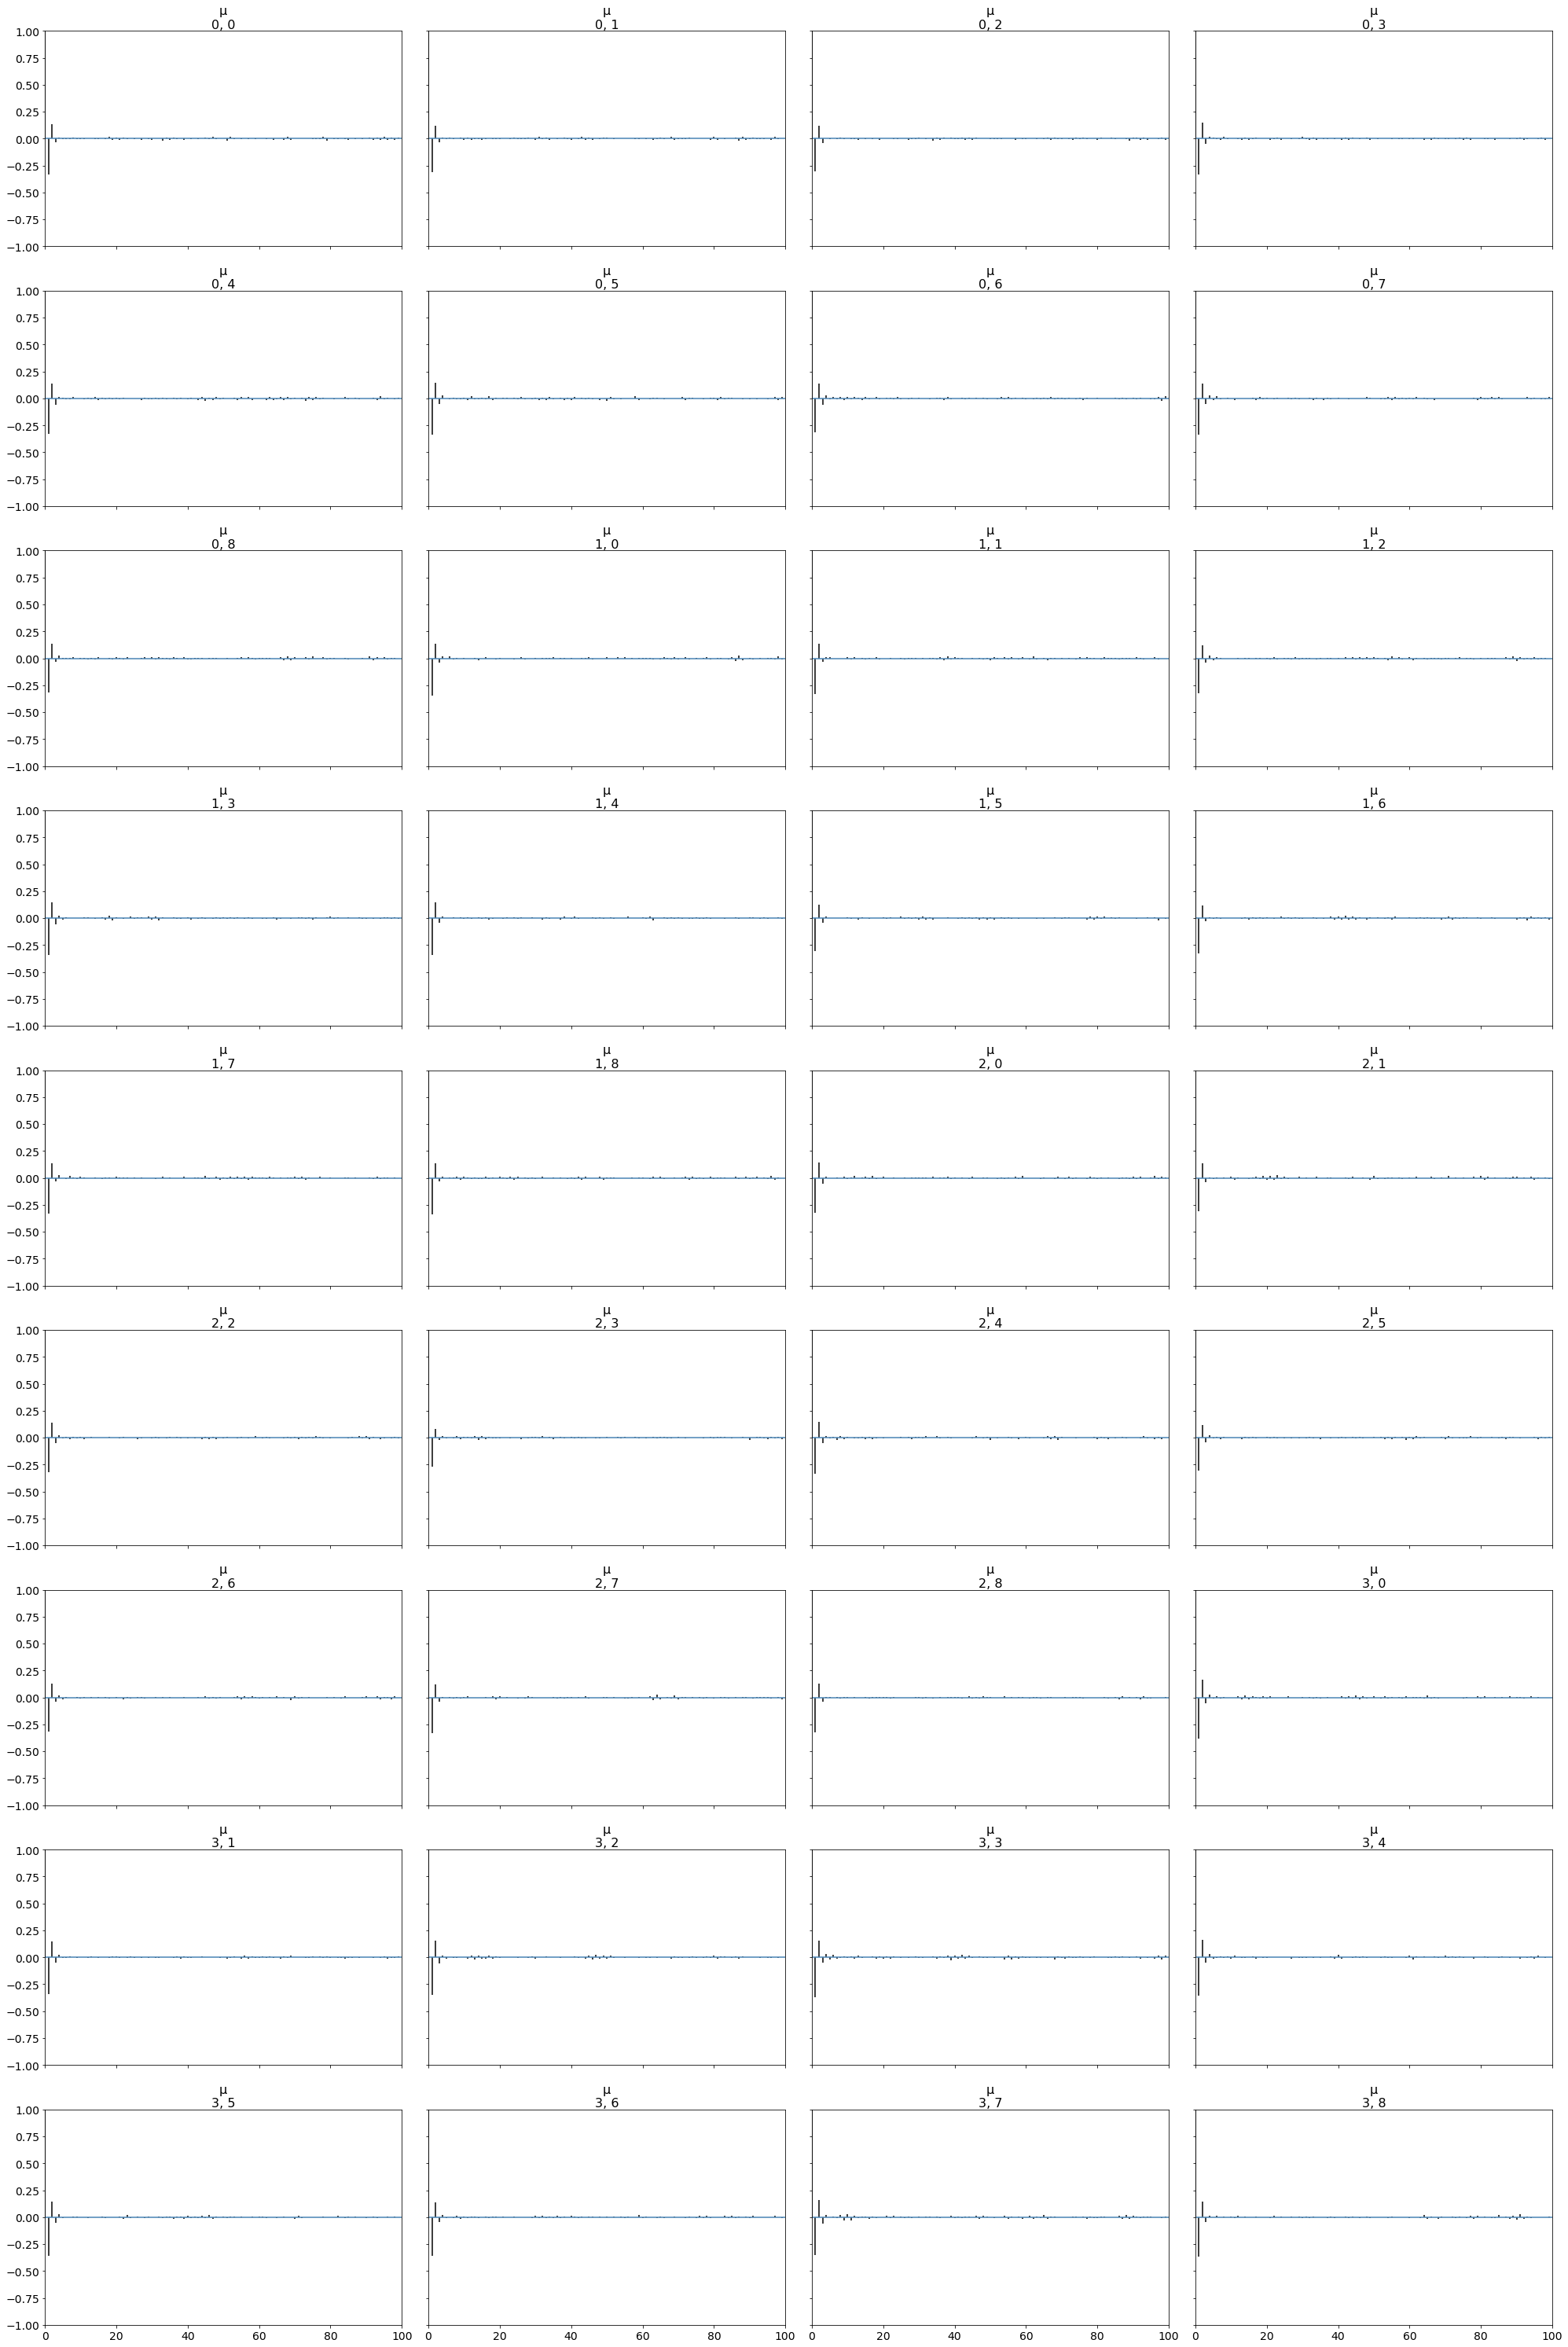

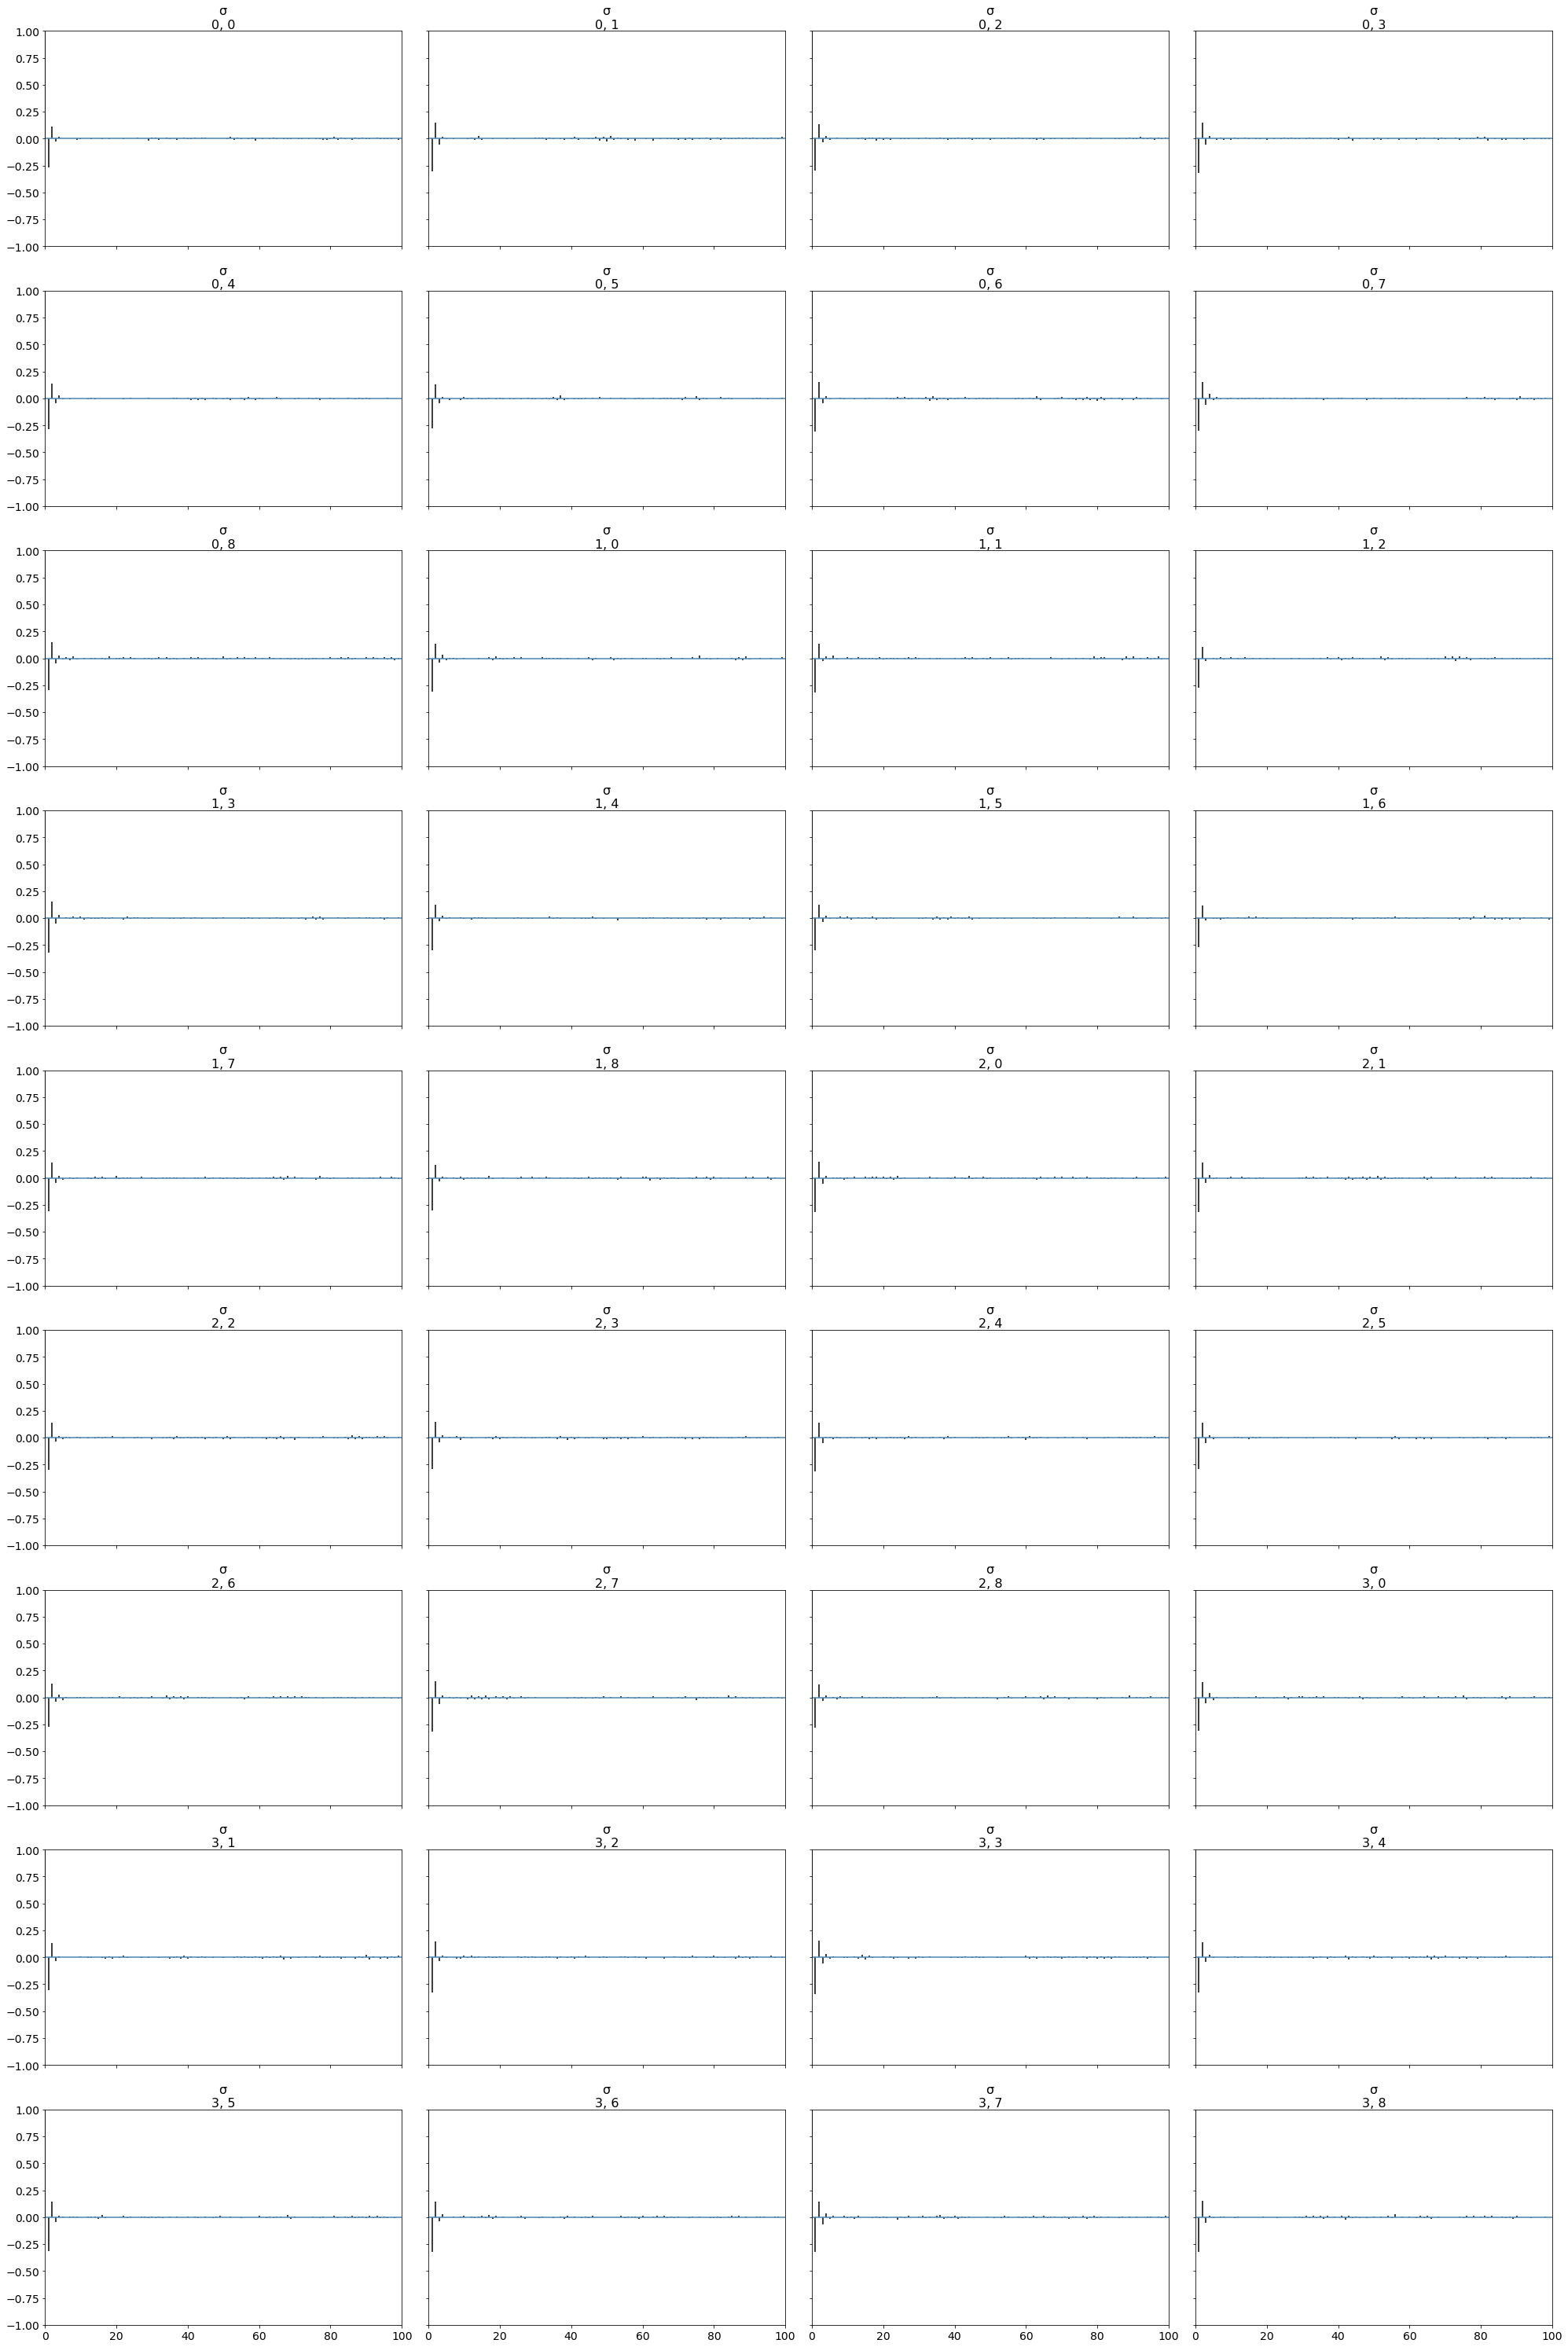

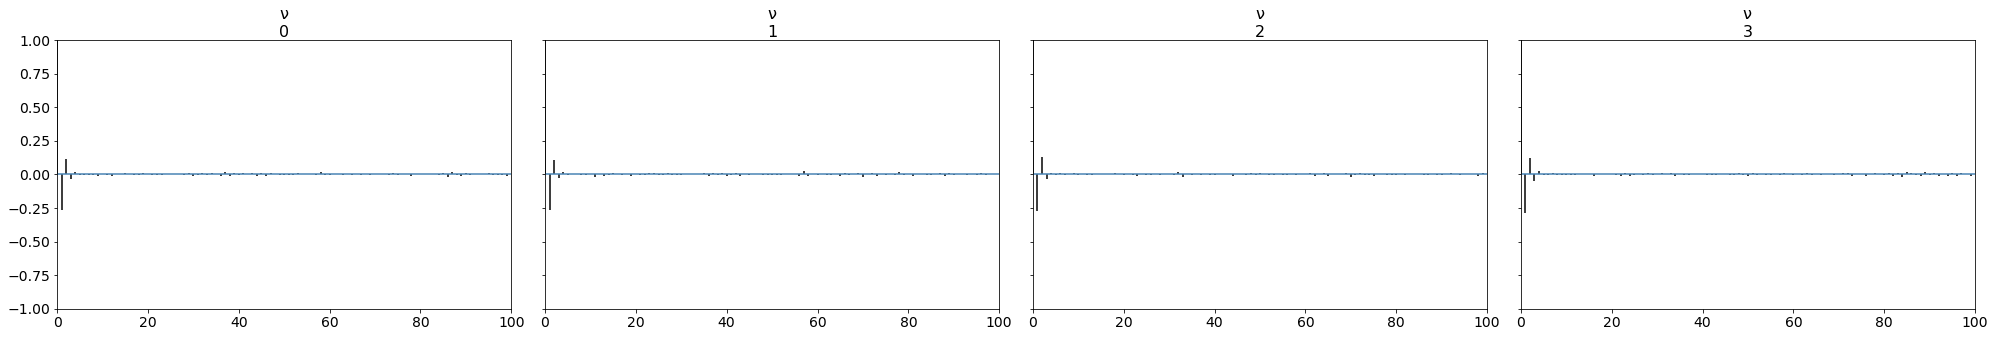

In [9]:
pm.autocorrplot(trace_TL, var_names=['μ'])
pm.autocorrplot(trace_TL, var_names=['σ'])
pm.autocorrplot(trace_TL, var_names=['ν']);

As you can see above, autocorrelation is about zero for all chains of three parameters which indicates the chains are random.

In [10]:
pm.summary(trace_TL)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],0.443,0.068,0.317,0.573,0.000,0.000,154040.0,147483.0,155117.0,63044.0,1.0
μ[1],0.211,0.058,0.101,0.321,0.000,0.000,148922.0,128211.0,149686.0,61762.0,1.0
μ[2],0.570,0.048,0.479,0.660,0.000,0.000,153204.0,151621.0,154460.0,65288.0,1.0
μ[3],0.334,0.060,0.221,0.447,0.000,0.000,151748.0,141815.0,153032.0,63585.0,1.0
μ[4],0.255,0.054,0.154,0.358,0.000,0.000,154473.0,142336.0,155548.0,63641.0,1.0
μ[5],0.673,0.051,0.576,0.768,0.000,0.000,152135.0,151040.0,153239.0,63519.0,1.0
μ[6],0.404,0.075,0.260,0.543,0.000,0.000,154870.0,146723.0,155976.0,65958.0,1.0
μ[7],0.306,0.054,0.205,0.407,0.000,0.000,154843.0,144525.0,156151.0,63289.0,1.0
μ[8],0.420,0.063,0.300,0.540,0.000,0.000,150136.0,143434.0,151473.0,62705.0,1.0
σ[0],0.334,0.052,0.245,0.433,0.000,0.000,132429.0,112328.0,158146.0,61810.0,1.0


The mcse_mean and mcse_sd values are 0. Hence I will have zero standard error on the posterior mean and Scale. Besides, all values of the r_hat are 1 which is a sign of a good convergence.

I now plot sampled values and graphically check the convergence.

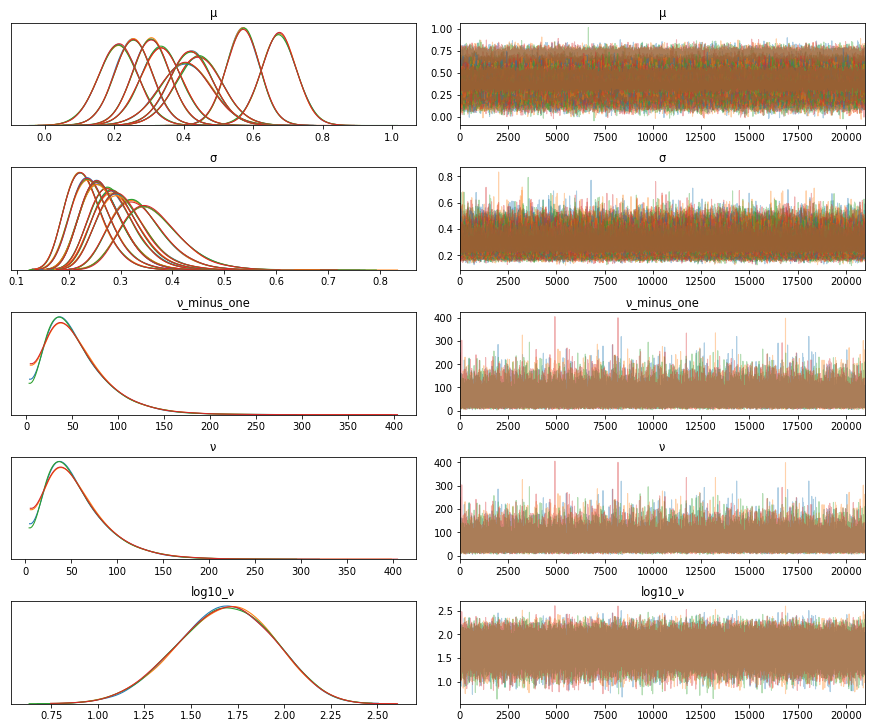

In [11]:
warnings.simplefilter('ignore', UserWarning) # To avoid printing the annoying user warning which is most likely a bug
pm.traceplot(trace_TL);

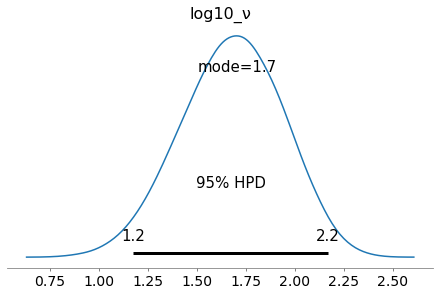

In [12]:
pm.plot_posterior(trace_TL, var_names=['log10_ν'], point_estimate='mode', credible_interval=.95);

The above plot indicates that the data have outliers since the 95% of its values are within [1.2, 2.2].

Ok, let's check if hypotheses in question hold. Before that, I want to make it clear why I am using the ROPE values ± 0.2 and ± 0.35. The former opts base on the belief that says a 20% difference is reasonable to make a decision whether a transform language performs better than the other one. The latter is chosen based on the standard deviation of collected data which is approximately 0.3.

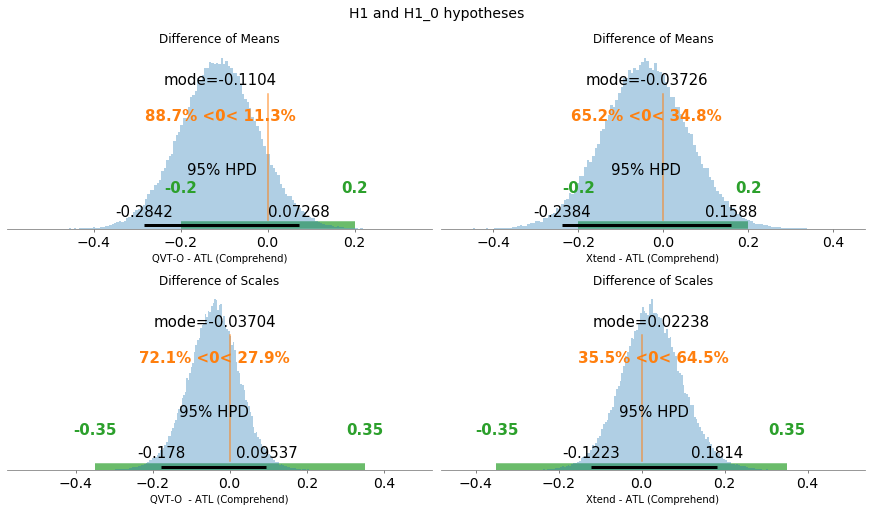

In [13]:
# Define gridspec
from matplotlib import gridspec
fig = plt.figure(constrained_layout=True, figsize=(12,7), facecolor='w', edgecolor='k')
gs = fig.add_gridspec(2, 6)
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:])

fig.suptitle('H1 and H1_0 hypotheses', fontsize='14')

pm.plot_posterior( trace_TL['μ'][:,3] - trace_TL['μ'][:,0],
         ax=ax1, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.2,+0.2)
    )
ax1.set_title("Difference of Means")
ax1.set_xlabel("QVT-O - ATL (Comprehend)")

pm.plot_posterior( trace_TL['μ'][:,6] - trace_TL['μ'][:,0],
         ax=ax2, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.2,+0.2)
    )
ax2.set_title("Difference of Means")
ax2.set_xlabel("Xtend - ATL (Comprehend)")

pm.plot_posterior( trace_TL['σ'][:,3] - trace_TL['σ'][:,0],
         ax=ax3, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.35,+0.35)
    )
ax3.set_title("Difference of Scales")
ax3.set_xlabel("QVT-O  - ATL (Comprehend)")

pm.plot_posterior( trace_TL['σ'][:,6] - trace_TL['σ'][:,0],
         ax=ax4, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.35,+0.35)
    )
ax4.set_title("Difference of Scales")
ax4.set_xlabel("Xtend - ATL (Comprehend)");

H1 and H1_0:
In the top histograms, the 95% HDI falls partially within the ROPE, so I cannot make any dicision! Even though the 95% HDI of the top right histogram is nearly falls within the ROPE it is better to do not make dicision.  

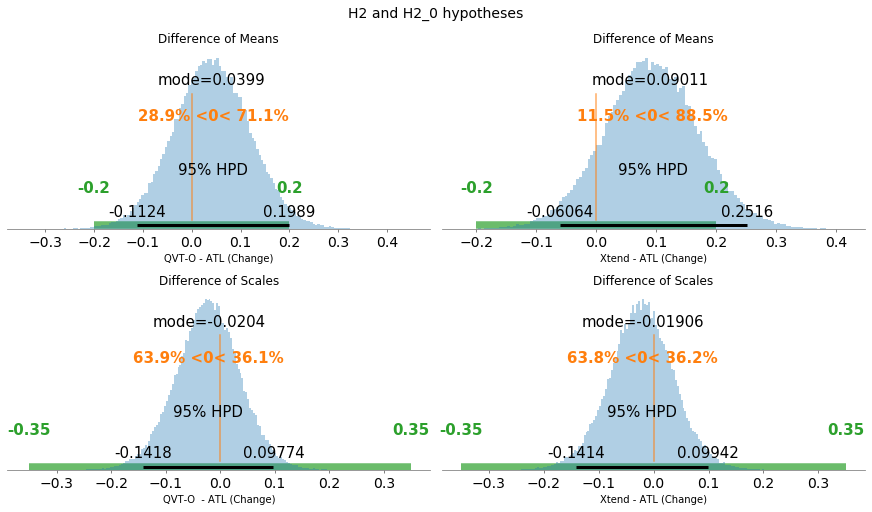

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(12,7), facecolor='w', edgecolor='k')
gs = fig.add_gridspec(2, 6)
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:])

fig.suptitle('H2 and H2_0 hypotheses', fontsize='14')

pm.plot_posterior( trace_TL['μ'][:,4] - trace_TL['μ'][:,1],
         ax=ax1, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.2,+0.2)
    )
ax1.set_title("Difference of Means")
ax1.set_xlabel("QVT-O - ATL (Change)")

pm.plot_posterior( trace_TL['μ'][:,7] - trace_TL['μ'][:,1],
         ax=ax2, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.2,+0.2)
    )
ax2.set_title("Difference of Means")
ax2.set_xlabel("Xtend - ATL (Change)")

pm.plot_posterior( trace_TL['σ'][:,4] - trace_TL['σ'][:,1],
         ax=ax3, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.35,+0.35)
    )
ax3.set_title("Difference of Scales")
ax3.set_xlabel("QVT-O  - ATL (Change)")

pm.plot_posterior( trace_TL['σ'][:,7] - trace_TL['σ'][:,1],
         ax=ax4, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.35,+0.35)
    )
ax4.set_title("Difference of Scales")
ax4.set_xlabel("Xtend - ATL (Change)");

H2 and H2_0: <br>
In the top left histogram, the 95% HDI of difference between QVT_O and ATL falls within the ROPE, so I conclude that there is no difference between the performance of QVT_O and ATL in this hypothesis. Therefore I reject the hypothesis as subjects who change a transformation written in QVT-O perform better than those who change a transformation in ATL. However, I cannot reject or accept hypothesis as Xtend performs better than ATL. That is I cannot make any decision about H2 hypothesis.

On the other hand, I accept the H2_0 hypothesis since the performance of QVT_O and ATL are equal. 
When using MCMC to estimate the HDI, the endpoints of HDI are not very precisely estimated hence I take the variation of estimation into account and assume the entire HDI falls within the ROPE in the top left histogram considering that only one of the endpoints has this condition. This assumption applies to all the decisions.  

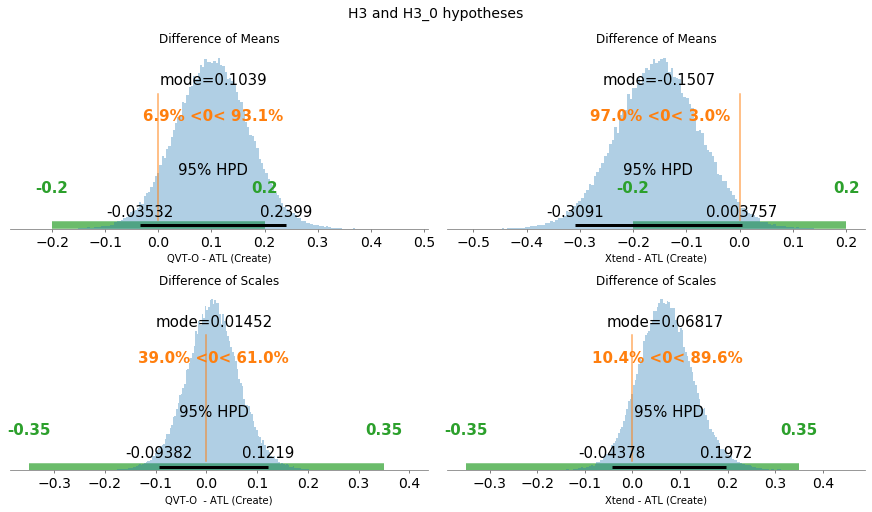

In [15]:
fig = plt.figure(constrained_layout=True, figsize=(12,7), facecolor='w', edgecolor='k')
gs = fig.add_gridspec(2, 6)
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:])

fig.suptitle('H3 and H3_0 hypotheses', fontsize='14')

pm.plot_posterior( trace_TL['μ'][:,5] - trace_TL['μ'][:,2],
         ax=ax1, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.2,+0.2)
    )
ax1.set_title("Difference of Means")
ax1.set_xlabel("QVT-O - ATL (Create)")

pm.plot_posterior( trace_TL['μ'][:,8] - trace_TL['μ'][:,2],
         ax=ax2, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.2,+0.2)
    )
ax2.set_title("Difference of Means")
ax2.set_xlabel("Xtend - ATL (Create)")

pm.plot_posterior( trace_TL['σ'][:,5] - trace_TL['σ'][:,2],
         ax=ax3, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.35,+0.35)
    )
ax3.set_title("Difference of Scales")
ax3.set_xlabel("QVT-O  - ATL (Create)")

pm.plot_posterior( trace_TL['σ'][:,8] - trace_TL['σ'][:,2],
         ax=ax4, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.35,+0.35)
    )
ax4.set_title("Difference of Scales")
ax4.set_xlabel("Xtend - ATL (Create)");

H3 and H3_0: <br>
In the top histograms, the 95% HDI falls partially within the ROPE, so I cannot make any dicision!  

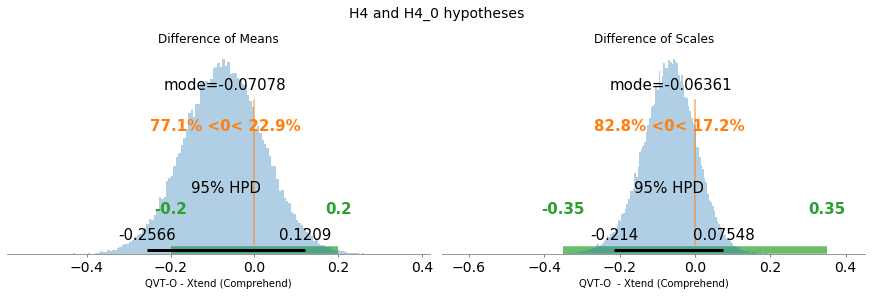

In [16]:
fig = plt.figure(constrained_layout=True, figsize=(12,4), facecolor='w', edgecolor='k')
gs = fig.add_gridspec(1, 6)
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:])

fig.suptitle('H4 and H4_0 hypotheses', fontsize='14')

pm.plot_posterior( trace_TL['μ'][:,3] - trace_TL['μ'][:,6],
         ax=ax1, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.2,+0.2)
    )
ax1.set_title("Difference of Means")
ax1.set_xlabel("QVT-O - Xtend (Comprehend)")

pm.plot_posterior( trace_TL['σ'][:,3] - trace_TL['σ'][:,6],
         ax=ax2, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.35,+0.35)
    )
ax2.set_title("Difference of Scales")
ax2.set_xlabel("QVT-O  - Xtend (Comprehend)");

H4 and H4_0: <br>
In the right histogram, the 95% HDI falls partially within the ROPE, so I cannot make any dicision!  

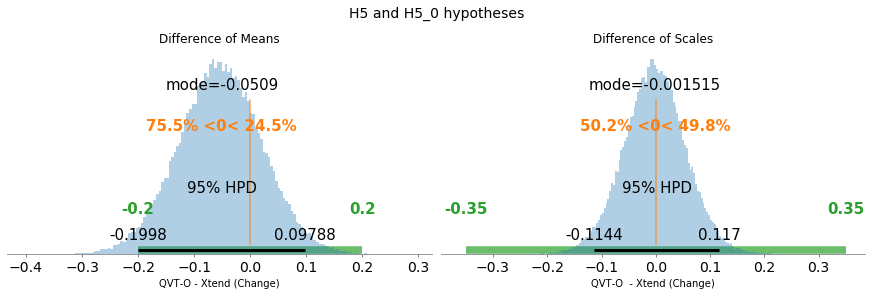

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(12,4), facecolor='w', edgecolor='k')
gs = fig.add_gridspec(1, 6)
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:])

fig.suptitle('H5 and H5_0 hypotheses', fontsize='14')

pm.plot_posterior( trace_TL['μ'][:,4] - trace_TL['μ'][:,7],
         ax=ax1, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.2,+0.2)
    )
ax1.set_title("Difference of Means")
ax1.set_xlabel("QVT-O - Xtend (Change)")

pm.plot_posterior( trace_TL['σ'][:,4] - trace_TL['σ'][:,7],
         ax=ax2, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.35,+0.35)
    )
ax2.set_title("Difference of Scales")
ax2.set_xlabel("QVT-O  - Xtend (Change)");

H5 and H5_0: <br>
In the right histogram, the 95% HDI falls within the ROPE, so I accept the H5 hypothesis and consequently reject the H5_0 hypothesis.

In the all above histograms of the difference of Scales, the 95% HDI falls nicely within the ROPE and suggests Qvt_O or Xtend does not introduce any difference in Scale.

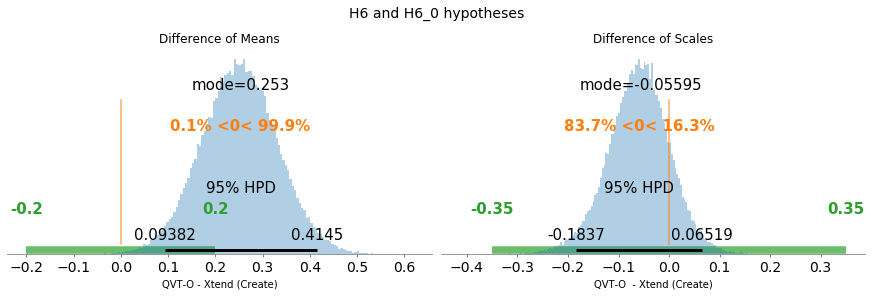

In [18]:
fig = plt.figure(constrained_layout=True, figsize=(12,4), facecolor='w', edgecolor='k')
gs = fig.add_gridspec(1, 6)
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:])

fig.suptitle('H6 and H6_0 hypotheses', fontsize='14')

pm.plot_posterior( trace_TL['μ'][:,5] - trace_TL['μ'][:,8],
         ax=ax1, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.2,+0.2)
    )
ax1.set_title("Difference of Means")
ax1.set_xlabel("QVT-O - Xtend (Create)")

pm.plot_posterior( trace_TL['σ'][:,5] - trace_TL['σ'][:,8],
         ax=ax2, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.35,+0.35)
    )
ax2.set_title("Difference of Scales")
ax2.set_xlabel("QVT-O  - Xtend (Create)");

H6 and H6_0: <br>
In the right histogram, the 95% HDI falls partially within the ROPE, so I cannot make any dicision!

In the histogram of the difference of Scales, the 95% HDI falls partially within the ROPE. It probably suggests that The third task, Create either in QVT-O or Xtend is tougher. Anyway, I cannot say that for sure since the HDI is not outside the ROPE.

Conclusion:
All in all the collected data is relatively small and that is most likely the reason the 95% HDI falls partially within the ROPE in most cases. That is, we can make a more robust decision if we collect more data. Finally, I will remind you that boolean decisions are huge oversimplifications of an outcome of Bayesian inference.